In [1]:
import numpy as np
import pandas as pd 
import anndata as ad
import scanpy as sc

import screenpro as scp

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=150, format='svg', frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

In [2]:
from screenpro.plotting import almost_black, dark2

In [3]:
# help(scp.phenoScore.getPhenotypeScore)

# help(scp.pl.plotReplicateScatter)

### load counts and metadata

In [4]:
meta = pd.read_excel('PRDX1samplesheet_incgrowth.xlsx',index_col=0)

In [5]:
adata = ad.read_h5ad('results/adata_counts.h5ad.gz')

del adata.layers

adata.obs.treatment = adata.obs.treatment.str.replace('-','T0')
adata.obs = adata.obs.rename(columns={'treatment':'condition','rep':'replicate'})

adata.obs['pop_doublings'] = meta['pop doublings'].replace('-',np.nan).astype(float)

___
- filter low counts

In [6]:
scp.utils.find_low_counts

<function screenpro.utils.find_low_counts(adata, filter_type='either', minimum_reads=50)>

In [7]:
adata.obs

,cell line,timepoint,condition,replicate,pop_doublings
index,,,,,
i01,parent,T0,T0,1,NaN
i02,parent,T0,T0,2,NaN
i03,parent,Tend,vehicle,1,8.099107
i04,parent,Tend,vehicle,2,7.760087
i05,parent,Tend,vehicle,3,7.799925
i06,parent,Tend,DNAPKi,1,7.459794
i07,parent,Tend,DNAPKi,2,7.541174
i08,parent,Tend,DNAPKi,3,7.709747
i09,PRDX1KO,T0,T0,1,NaN


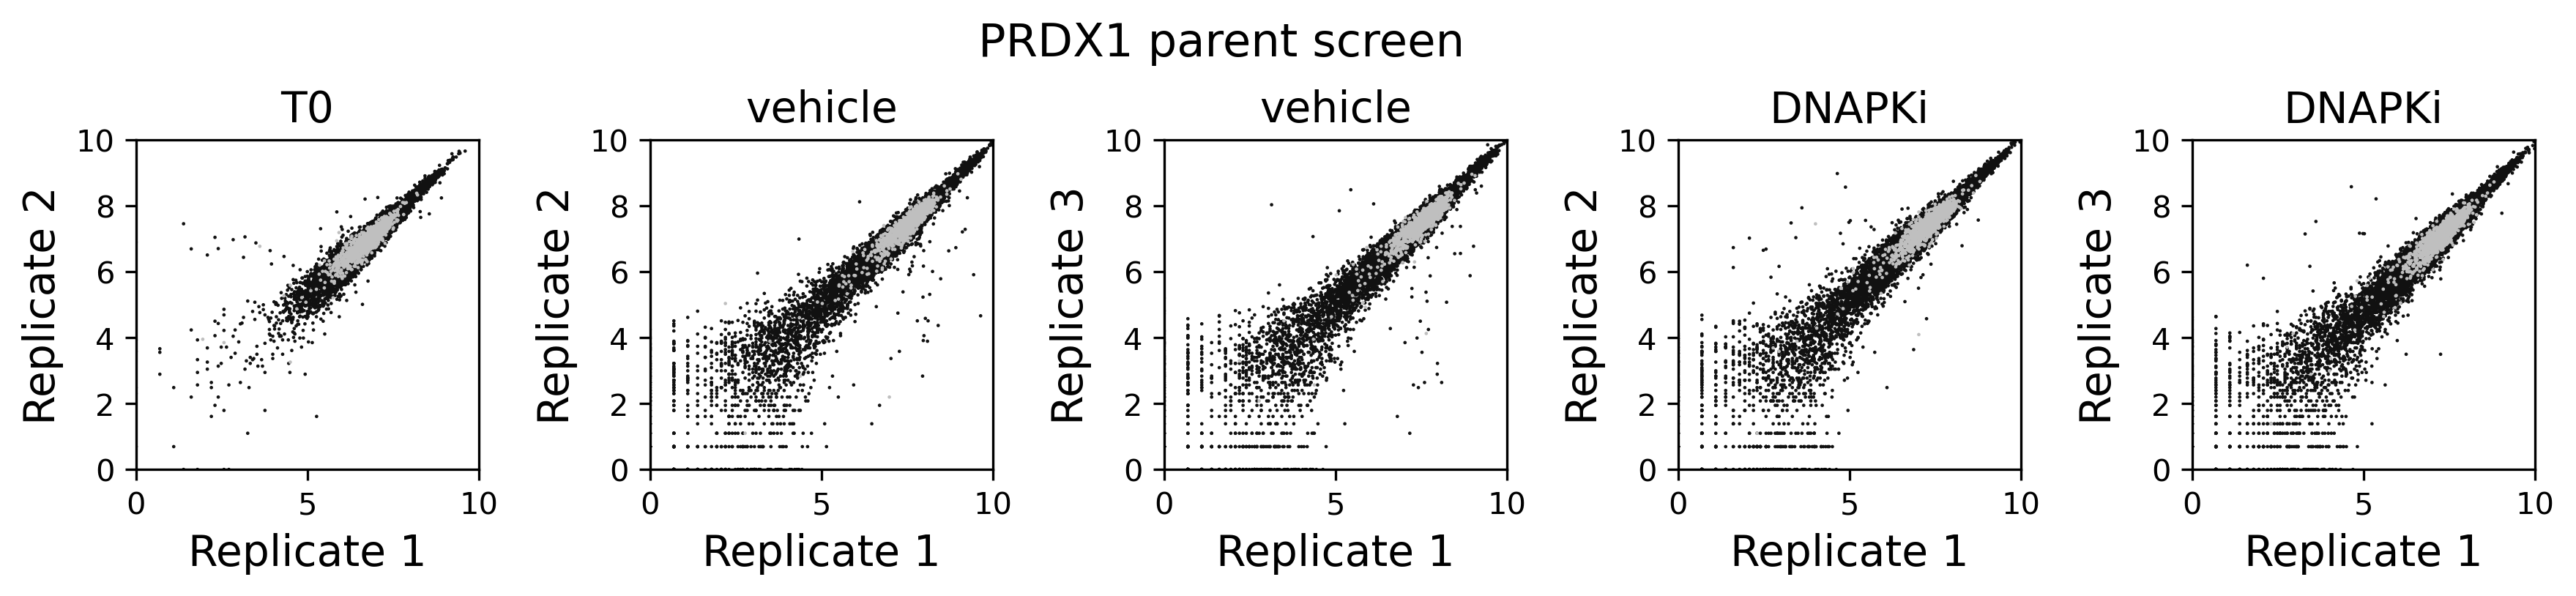

In [8]:
fig, axes = plt.subplots(ncols=5,
                         figsize=(13,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], adata, 'i01','i02','T0',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[1], adata, 'i03','i04','vehicle',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[2], adata, 'i03','i05','vehicle',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[3], adata, 'i06','i07','DNAPKi',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[4], adata, 'i06','i08','DNAPKi',min_val=0,max_val=10)

fig.suptitle('PRDX1 parent screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

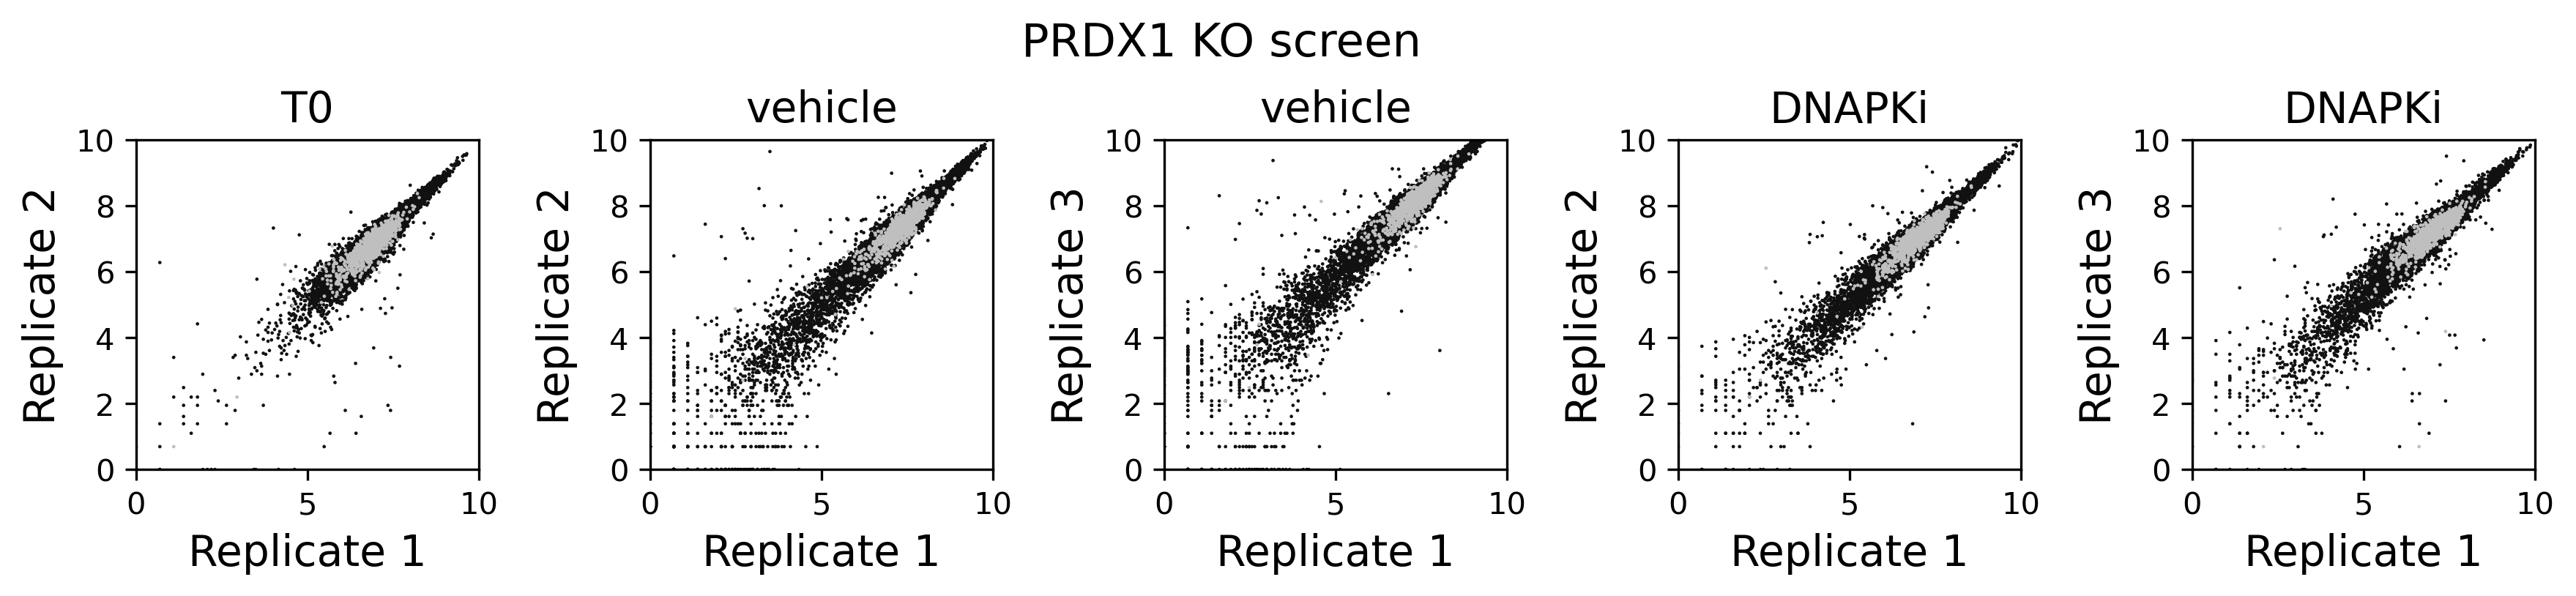

In [9]:
fig, axes = plt.subplots(ncols=5,
                         figsize=(13,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], adata, 'i09','i10','T0',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[1], adata, 'i11','i12','vehicle',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[2], adata, 'i11','i13','vehicle',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[3], adata, 'i14','i15','DNAPKi',min_val=0,max_val=10)
scp.pl.plotReplicateScatter(axes[4], adata, 'i14','i16','DNAPKi',min_val=0,max_val=10)

fig.suptitle('PRDX1 KO screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

### scores

    'PRDX1_parent gamma vehicle_vs_T0',
    'PRDX1_parent rho DNAPKi_vs_vehicle',
    'PRDX1_parent tau DNAPKi_vs_T0',

    'PRDX1_KO gamma vehicle_vs_T0',
    'PRDX1_KO rho DNAPKi_vs_vehicle',
    'PRDX1_KO tau DNAPKi_vs_T0',
<!--     'rho vehicle_PRDX1KO_vs_vehicle_parent' -->

___

In [10]:
adata_PRDX1KO = adata[adata.obs['cell line'].eq('PRDX1KO')].copy()
adata_parent  = adata[adata.obs['cell line'].eq('parent')].copy()

### PRDX1 parent screen

In [11]:
screen0 = scp.ScreenPro(adata_parent)
screen = scp.ScreenPro(adata_parent[adata_parent.obs.replicate.isin([1,2])].copy(),n_reps=2)

screen.adata.obs

,cell line,timepoint,condition,replicate,pop_doublings
index,,,,,
i01,parent,T0,T0,1,NaN
i02,parent,T0,T0,2,NaN
i03,parent,Tend,vehicle,1,8.099107
i04,parent,Tend,vehicle,2,7.760087
i06,parent,Tend,DNAPKi,1,7.459794
i07,parent,Tend,DNAPKi,2,7.541174


___

In [12]:
scp.utils.find_low_counts(screen.adata)

41 variables with less than 50 reads in either replicates / experiment


In [13]:
# screen.adata = screen.adata[:,~screen.adata.var.low_count].copy()

In [14]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi',
    db_untreated = 7.8,
    db_treated = 7.5,
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [15]:
help(scp.pl.plot_volcano)

Help on function plot_volcano in module screenpro.plotting:

plot_volcano(ax, df_in, threshold, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6)



In [16]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

tau = screen.phenotypes['compare_reps']['tau:DNAPKi_vs_T0'].iloc[:,:3].reset_index(drop=True)

rho = screen.phenotypes['compare_reps']['rho:DNAPKi_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

In [17]:
gamma.score.min(),gamma.score.max(), max(-np.log10(gamma['ttest pvalue']))

(-1.3132431859088012, 0.6377828362087014, 4.164796743418543)

In [18]:
tau.score.min(),tau.score.max(),max(-np.log10(tau['ttest pvalue']))

(-1.3818949132380811, 0.7685057381778418, 5.308144812303813)

In [19]:
rho.score.min(),rho.score.max(),max(-np.log10(rho['ttest pvalue']))

(-15.99040372685073, 19.48810532944987, 5.411105270877575)

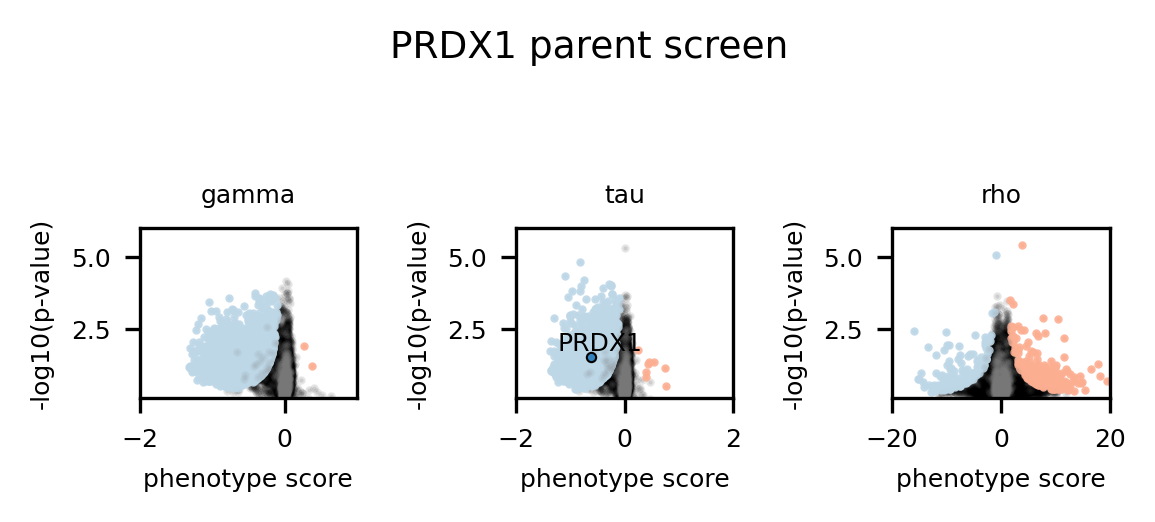

In [20]:
# Create subplots and specify the size
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(4, 1.8))

scp.pl.plot_volcano(ax1, gamma,threshold=5,xlim_l=-2, xlim_r=1)
ax1.grid(False)
ax1.get_legend().remove()
ax1.set_title('gamma')

scp.pl.plot_volcano(ax2, tau,threshold=5,xlim_l=-2, xlim_r=2)
scp.pl.label_sensitivity_hit(ax2,tau,'PRDX1',threshold=5,size=5,size_txt=6,t_x=-.6,t_y=.2)

ax2.grid(False)
ax2.get_legend().remove()
ax2.set_title('tau')

scp.pl.plot_volcano(ax3, rho,threshold=5,xlim_l=-20, xlim_r=20)
# label_resistance_hit(ax2,rho,'TTC1',size=5,size_txt=6,t_x=.1)
# label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.1)

ax3.grid(False)
ax3.get_legend().remove()
ax3.set_title('rho')


for ax in [ax1,ax2,ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

fig.suptitle('PRDX1 parent screen',fontsize=9)
plt.tight_layout()
# Show the plot
plt.show()

#### replicate level scores

In [30]:
scp.utils.calculateGrowthFactor(screen0, untreated = 'vehicle', treated = 'DNAPKi', db_rate_col = 'pop_doublings')

,score,growth_factor,replicate
0,gamma,8.099107,1
1,tau,7.459794,1
2,rho,0.639312,1
3,gamma,7.760087,2
4,tau,7.541174,2
5,rho,0.218913,2
6,gamma,7.799925,3
7,tau,7.709747,3
8,rho,0.090178,3


In [24]:
growth_factor_table = calculateGrowthFactor(screen0, untreated = 'vehicle', treated = 'DNAPKi', db_rate_col = 'pop_doublings')

In [35]:
pdata = ad.AnnData(
    X=pd.concat([
        scp.ps.runPhenoScoreForReplicate(screen,'T0', 'vehicle','gamma',growth_factor_table).add_prefix('gamma_'),
        scp.ps.runPhenoScoreForReplicate(screen,'T0', 'DNAPKi','tau',growth_factor_table).add_prefix('tau_'),
        scp.ps.runPhenoScoreForReplicate(screen0,'vehicle', 'DNAPKi','rho',growth_factor_table).add_prefix('rho_')
    ],axis=1).T,
    var=screen.adata.var
)

pdata.obs['score'] = pdata.obs.index.str.split('_').str[0]
pdata.obs['replicate'] = pdata.obs.index.str.split('_').str[2]

In [36]:
pdata

AnnData object with n_obs × n_vars = 7 × 21097
    obs: 'score', 'replicate'
    var: 'target', 'targetType', 'low_count'

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


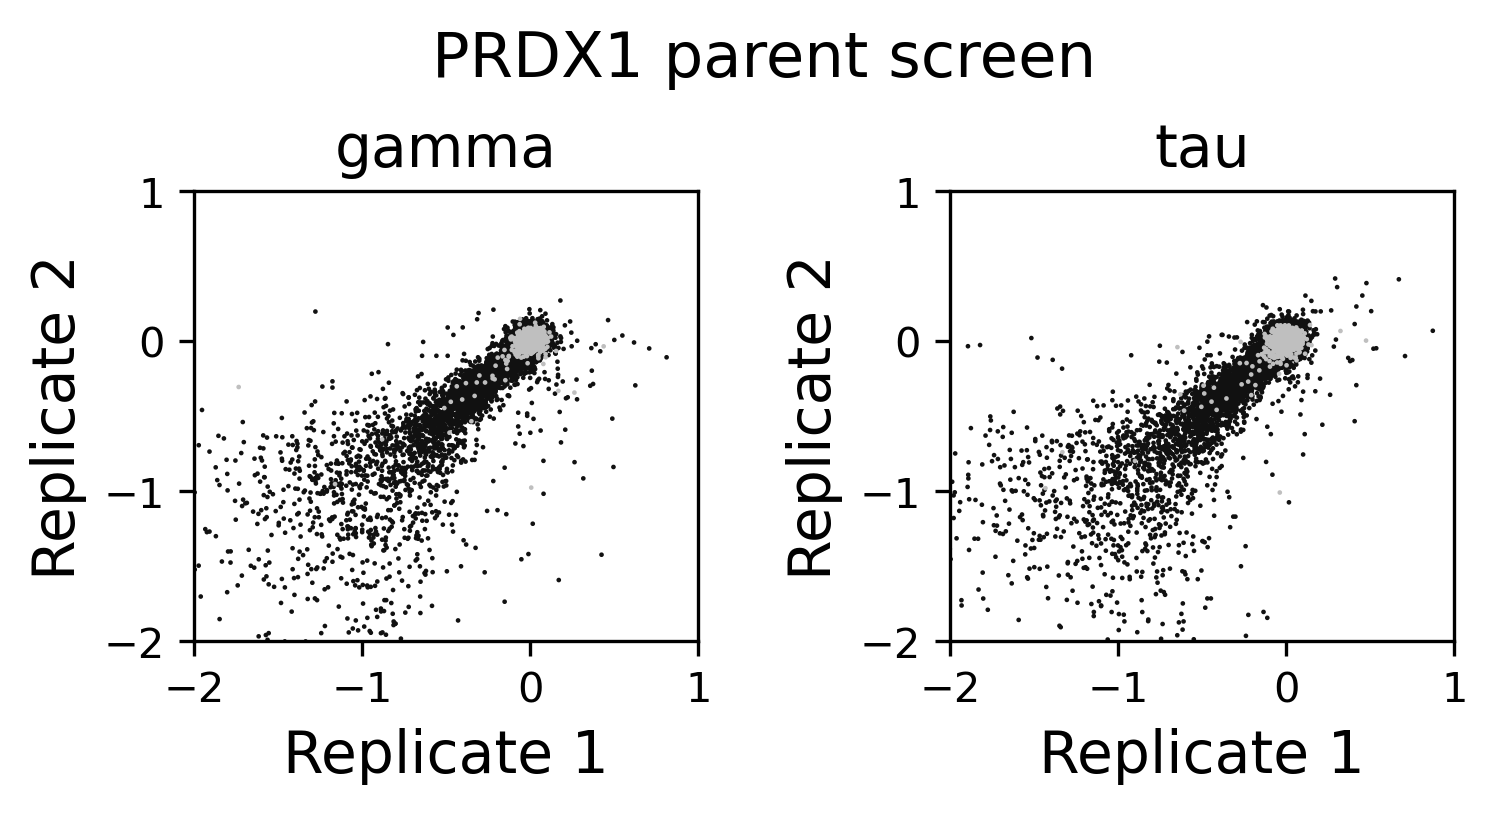

In [37]:
fig, axes = plt.subplots(ncols=2,
                         figsize=(5,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], pdata, 'gamma_replicate_1','gamma_replicate_2','gamma',max_val=1)
scp.pl.plotReplicateScatter(axes[1], pdata, 'tau_replicate_1','tau_replicate_2','tau',max_val=1)


fig.suptitle('PRDX1 parent screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

### PRDX1 KO screen

In [49]:
screen0 = scp.ScreenPro(adata_PRDX1KO)
screen = scp.ScreenPro(adata_PRDX1KO[adata_PRDX1KO.obs.replicate.isin([1,2])].copy(),n_reps=2)

screen.adata.obs


screen.adata.obs

,cell line,timepoint,condition,replicate,pop_doublings,size_factors
index,,,,,,
i09,PRDX1KO,T0,T0,1,NaN,0.750012
i10,PRDX1KO,T0,T0,2,NaN,0.696531
i11,PRDX1KO,Tend,vehicle,1,6.939640,1.076080
i12,PRDX1KO,Tend,vehicle,2,7.325594,1.094670
i14,PRDX1KO,Tend,DNAPKi,1,1.949450,0.834471
i15,PRDX1KO,Tend,DNAPKi,2,2.113679,0.862563


In [50]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi',
    db_untreated = 7.1,
    db_treated = 2.1,
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [51]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

tau = screen.phenotypes['compare_reps']['tau:DNAPKi_vs_T0'].iloc[:,:3].reset_index(drop=True)

rho = screen.phenotypes['compare_reps']['rho:DNAPKi_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

In [52]:
gamma.score.min(),gamma.score.max(), max(-np.log10(gamma['ttest pvalue']))

(-1.6069724680106285, 0.6605598916948526, 4.242104083542159)

In [53]:
tau.score.min(),tau.score.max(),max(-np.log10(tau['ttest pvalue']))

(-4.494193360329573, 2.5849071720895833, 4.352980351668554)

In [54]:
rho.score.min(),rho.score.max(),max(-np.log10(rho['ttest pvalue']))

(-0.6165076479446847, 1.4355753897235608, 4.426303323333478)

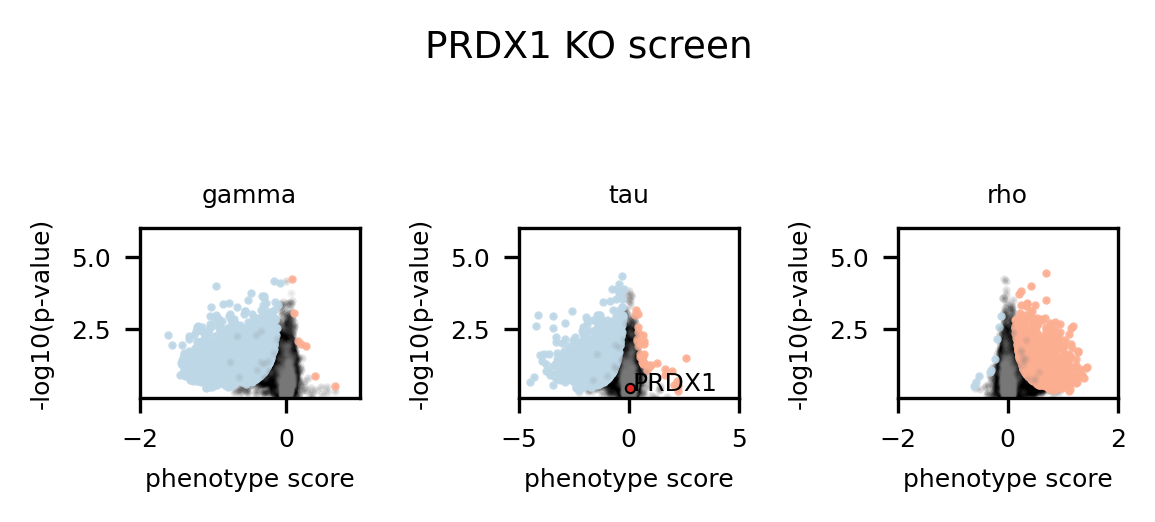

In [55]:
# Create subplots and specify the size
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(4, 1.8))

scp.pl.plot_volcano(ax1, gamma,threshold=5,xlim_l=-2, xlim_r=1)
ax1.grid(False)
ax1.get_legend().remove()
ax1.set_title('gamma')

scp.pl.plot_volcano(ax2, tau,threshold=5,xlim_l=-5, xlim_r=5)
scp.pl.label_resistance_hit(ax2,tau,'PRDX1',threshold=5,size=5,size_txt=6,t_x=.1)
# label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.1)

ax2.grid(False)
ax2.get_legend().remove()
ax2.set_title('tau')

scp.pl.plot_volcano(ax3, rho,threshold=5,xlim_l=-2, xlim_r=2)
# label_resistance_hit(ax2,rho,'TTC1',size=5,size_txt=6,t_x=.1)
# label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.1)

ax3.grid(False)
ax3.get_legend().remove()
ax3.set_title('rho')


for ax in [ax1,ax2,ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

fig.suptitle('PRDX1 KO screen',fontsize=9)
plt.tight_layout()
# Show the plot
plt.show()

In [58]:
growth_factor_table = scp.utils.calculateGrowthFactor(screen0, untreated = 'vehicle', treated = 'DNAPKi', db_rate_col = 'pop_doublings')

In [59]:
pdata = ad.AnnData(
    X=pd.concat([
        scp.ps.runPhenoScoreForReplicate(screen,'T0', 'vehicle','gamma',growth_factor_table).add_prefix('gamma_'),
        scp.ps.runPhenoScoreForReplicate(screen,'T0', 'DNAPKi','tau',growth_factor_table).add_prefix('tau_'),
        scp.ps.runPhenoScoreForReplicate(screen0,'vehicle', 'DNAPKi','rho',growth_factor_table).add_prefix('rho_')
    ],axis=1).T,
    var=screen.adata.var
)

pdata.obs['score'] = pdata.obs.index.str.split('_').str[0]
pdata.obs['replicate'] = pdata.obs.index.str.split('_').str[2]

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


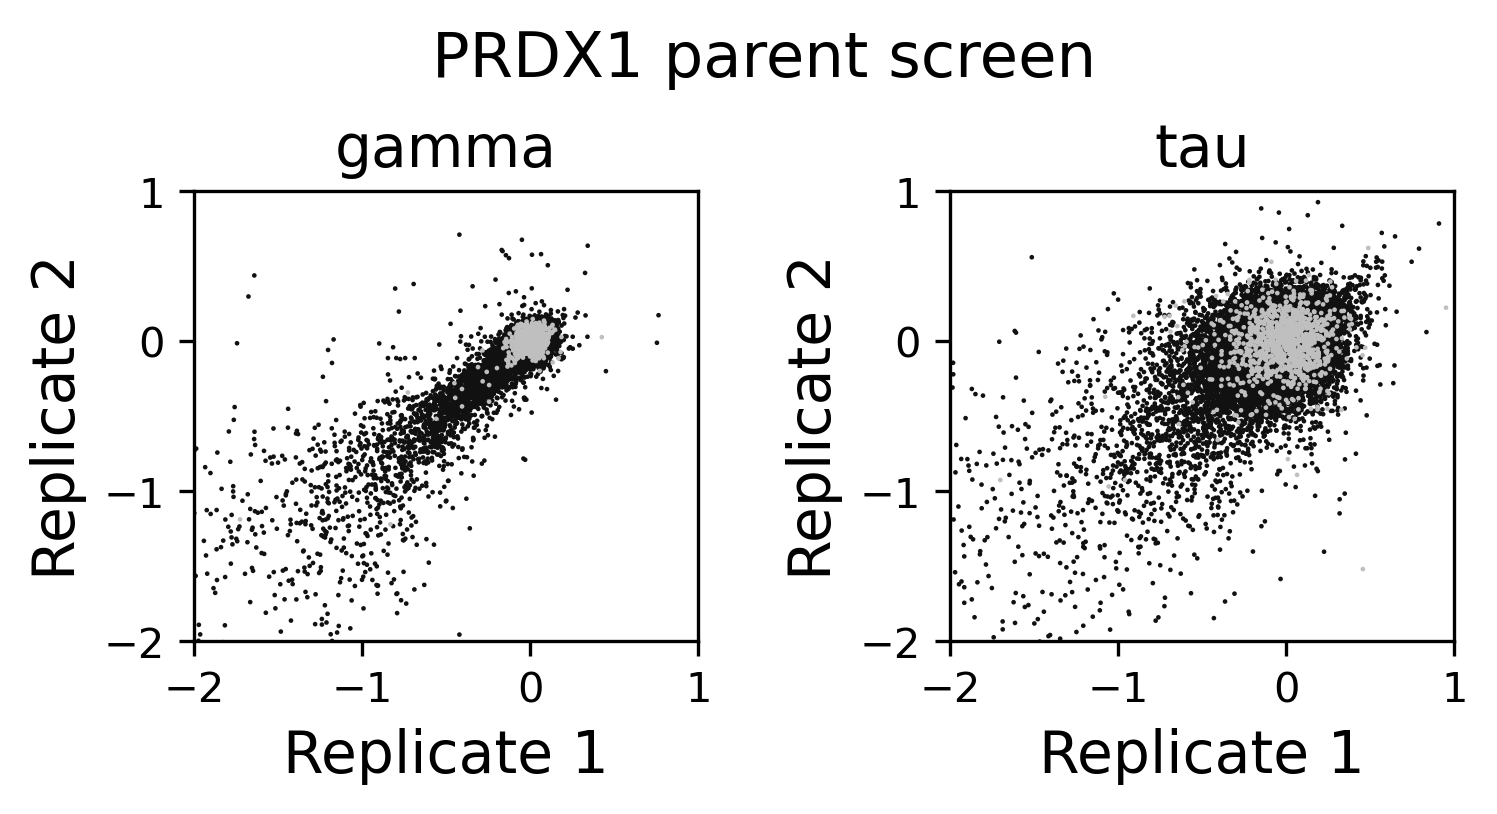

In [61]:
fig, axes = plt.subplots(ncols=2,
                         figsize=(5,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], pdata, 'gamma_replicate_1','gamma_replicate_2','gamma',max_val=1)
scp.pl.plotReplicateScatter(axes[1], pdata, 'tau_replicate_1','tau_replicate_2','tau',max_val=1)


fig.suptitle('PRDX1 parent screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

# 

In [66]:
%reload_ext watermark

In [67]:
%watermark

Last updated: 2023-12-19T19:34:05.876664-08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [68]:
%watermark --iversions

numpy     : 1.24.4
pandas    : 1.5.3
scanpy    : 1.9.3
matplotlib: 3.7.2
anndata   : 0.9.1
screenpro : 0.2.5



In [65]:
!date

Tue Dec 19 19:33:34 PST 2023
